In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#import tensorflow.keras.optimizers
import tensorflow.compat.v1
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from datetime import datetime

# Read your CSV file
df = pd.read_csv('./smart_grid_stability_augmented.csv')

# Drop rows with missing values
df.dropna(inplace=True)

# Filter out infinity values only from numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
for column in numeric_columns:
    is_infinite = np.isinf(df[column])
    df = df[~is_infinite]

# Remove columns with all 0 values
zero_columns = df.columns[(df == 0).all()]
df = df.drop(columns=zero_columns)

print('The dataset contains', df.shape[0], 'rows and', df.shape[1], 'columns')
df.head()

The dataset contains 60000 rows and 14 columns


,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,marker
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,Attack
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,Natural
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,Attack
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,Attack
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,Attack


In [2]:
print(df.columns)



Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4', 'stab', 'marker'],
      dtype='object')


In [3]:
df.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,5.250000,5.250001,5.250001,5.250001,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731
std,2.742434,2.742437,2.742437,2.742437,0.752129,0.433017,0.433017,0.433017,0.274244,0.274243,0.274243,0.274243,0.036917
min,0.500793,0.500141,0.500141,0.500141,1.582590,-1.999945,-1.999945,-1.999945,0.050009,0.050028,0.050028,0.050028,-0.080760
25%,2.874892,2.875011,2.875011,2.875011,3.218300,-1.624997,-1.624997,-1.624997,0.287521,0.287497,0.287497,0.287497,-0.015557
50%,5.250004,5.249981,5.249981,5.249981,3.751025,-1.249996,-1.249996,-1.249996,0.525009,0.525007,0.525007,0.525007,0.017142
75%,7.624690,7.624896,7.624896,7.624896,4.282420,-0.874993,-0.874993,-0.874993,0.762435,0.762490,0.762490,0.762490,0.044878
max,9.999469,9.999837,9.999837,9.999837,5.864418,-0.500025,-0.500025,-0.500025,0.999937,0.999982,0.999982,0.999982,0.109403


C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


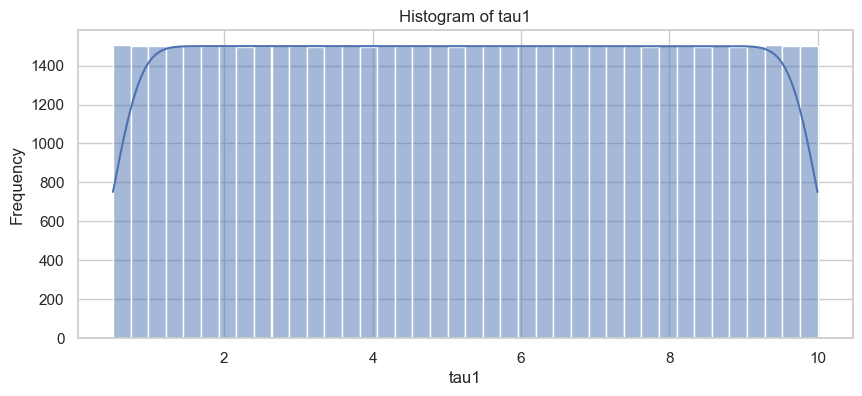

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


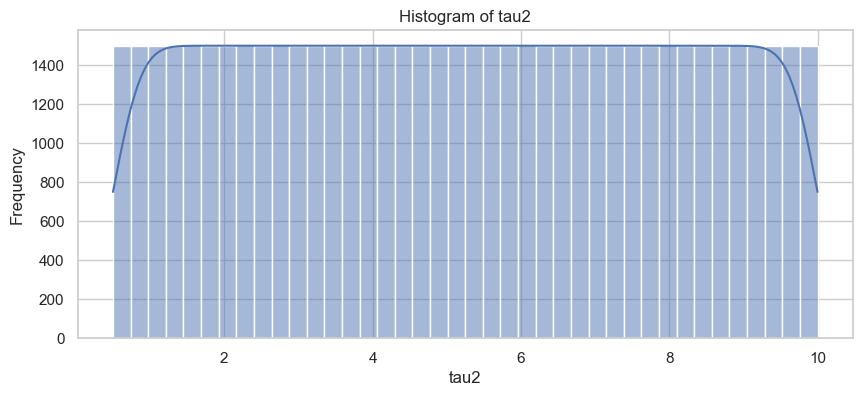

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


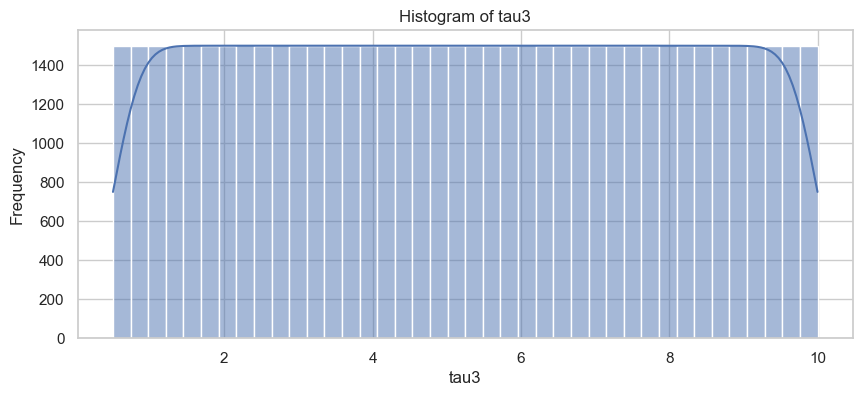

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


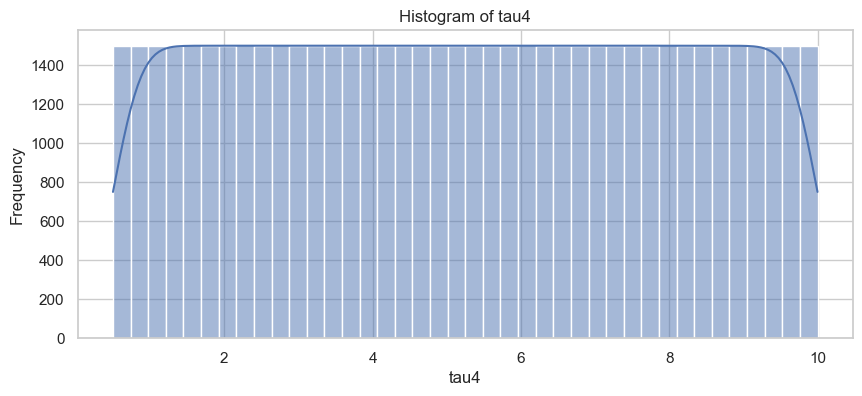

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


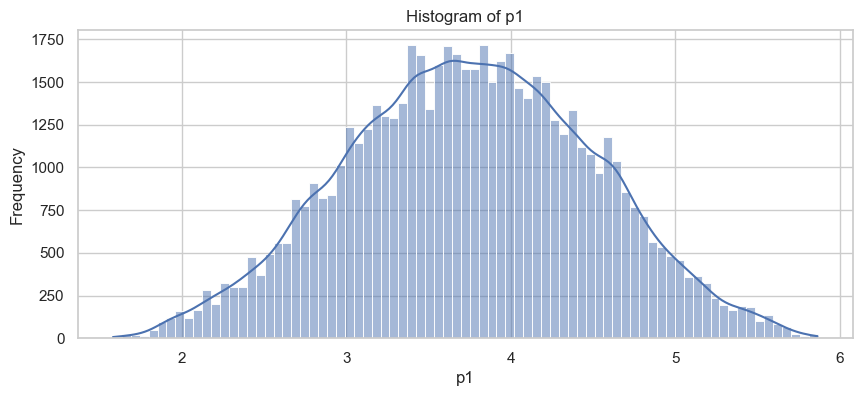

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


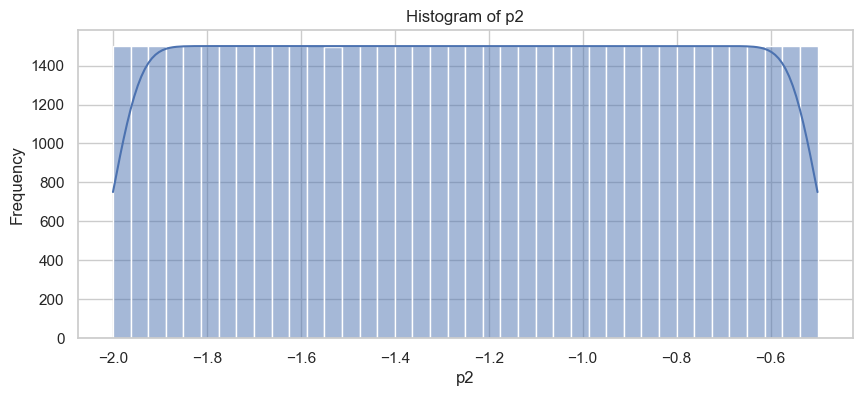

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


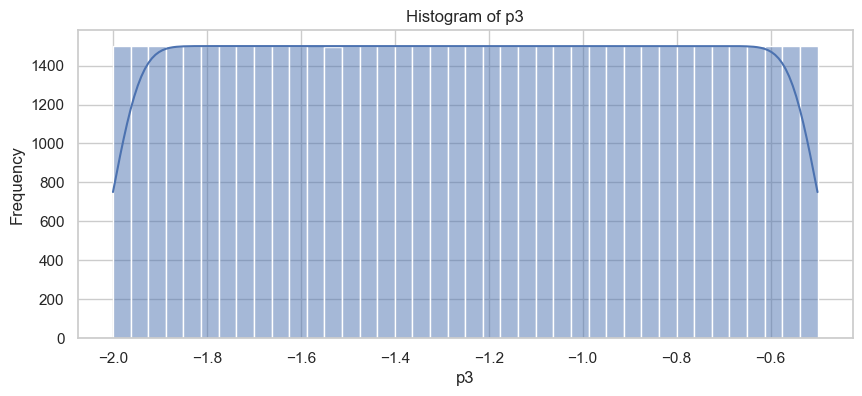

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


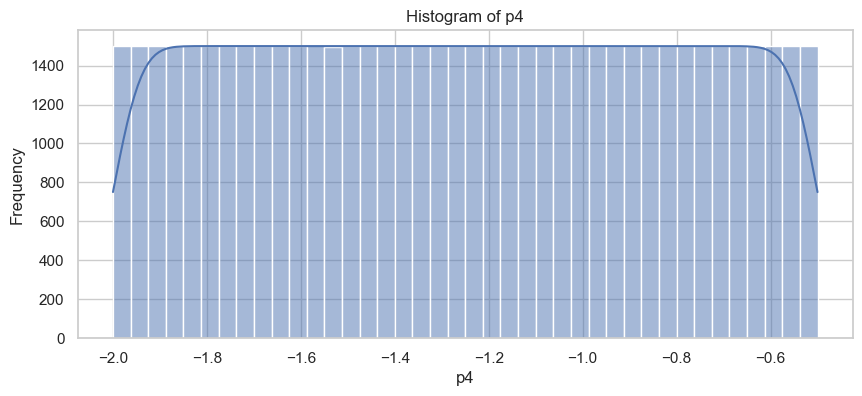

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


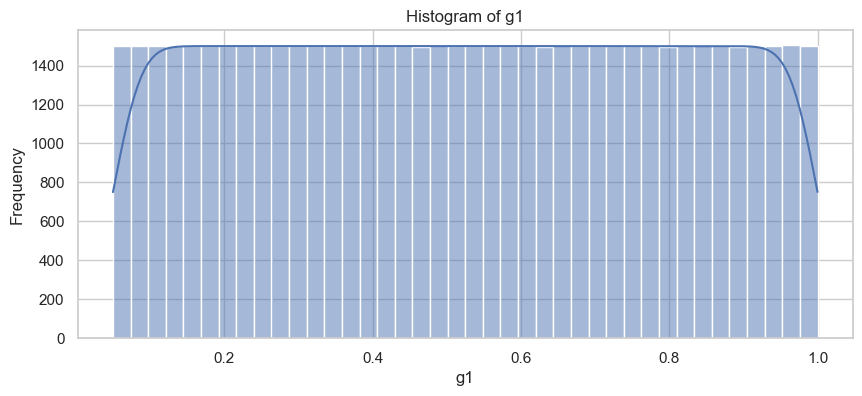

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


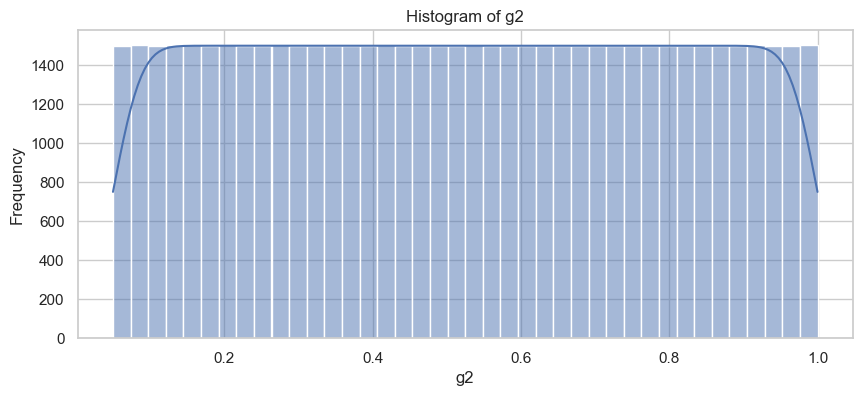

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


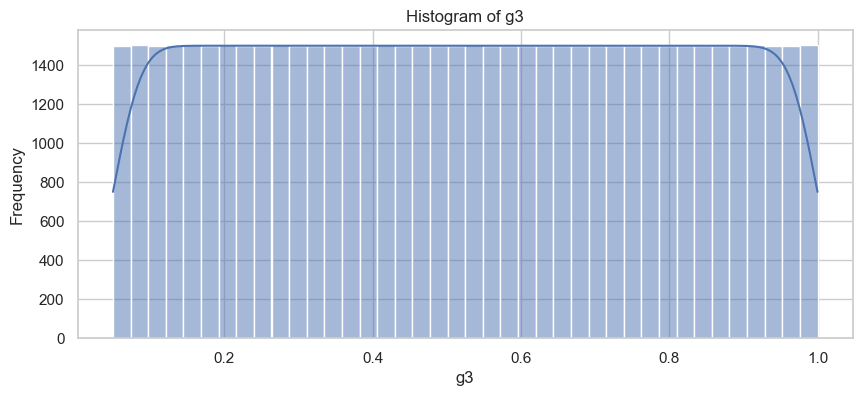

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


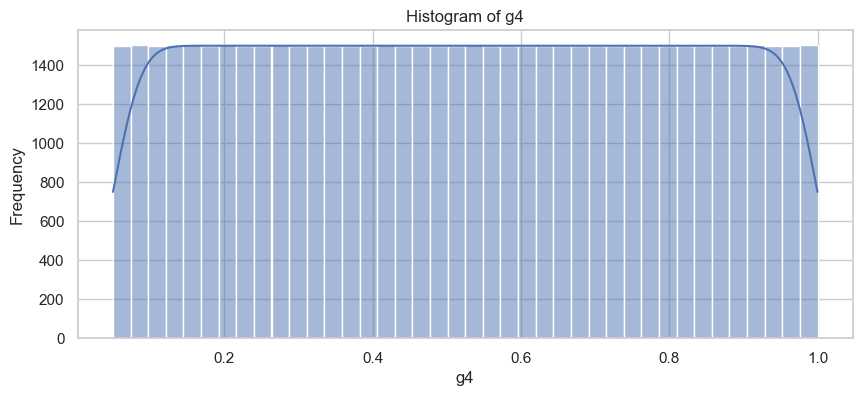

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


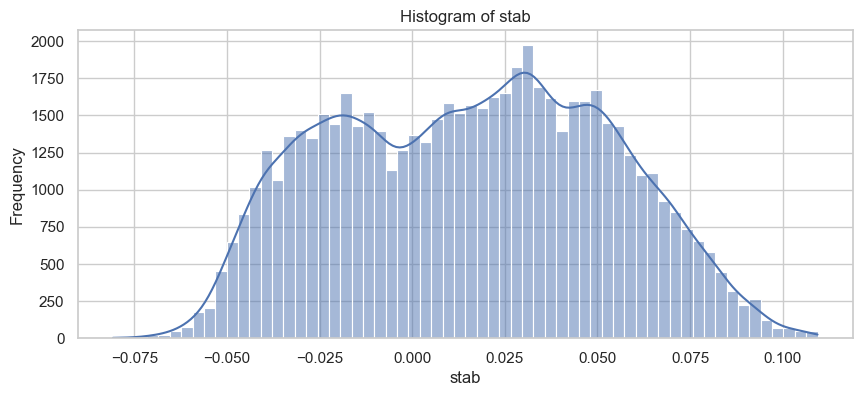

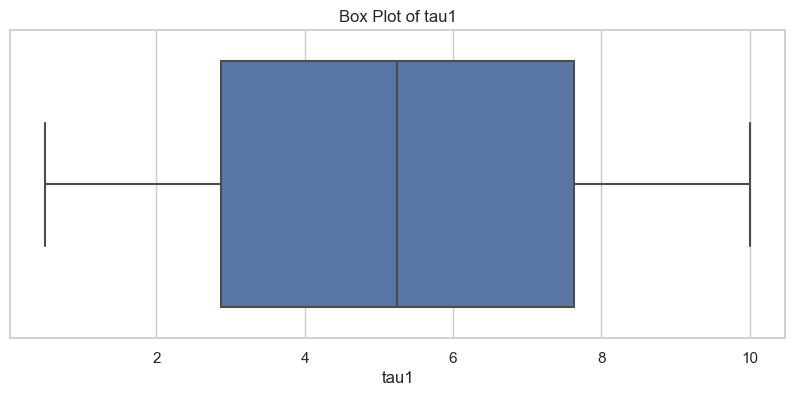

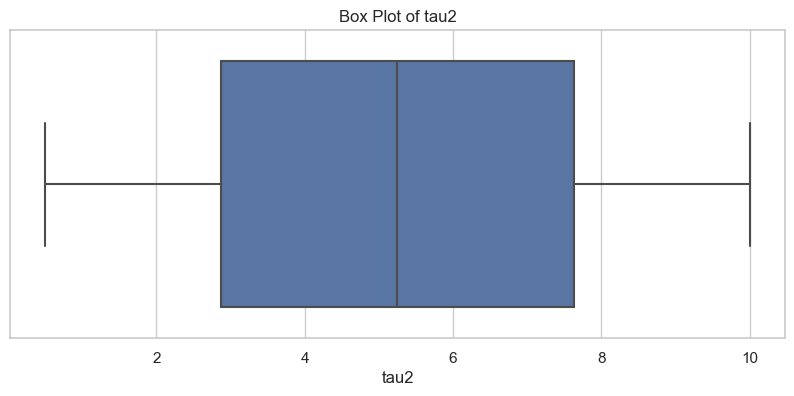

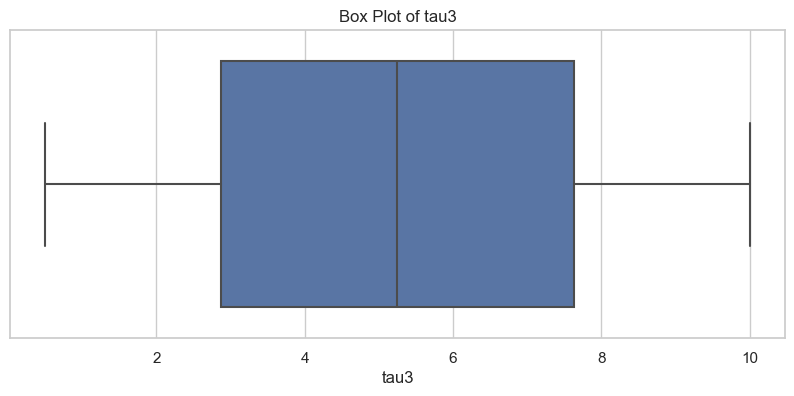

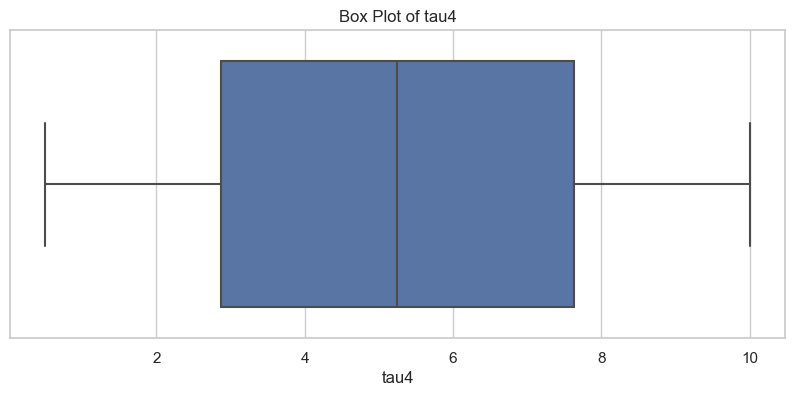

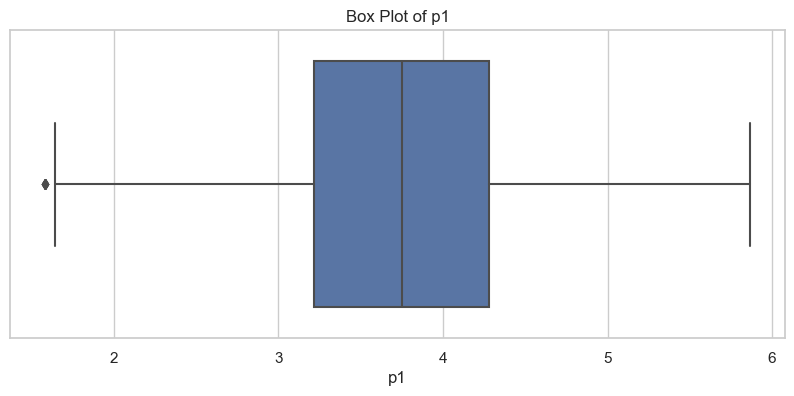

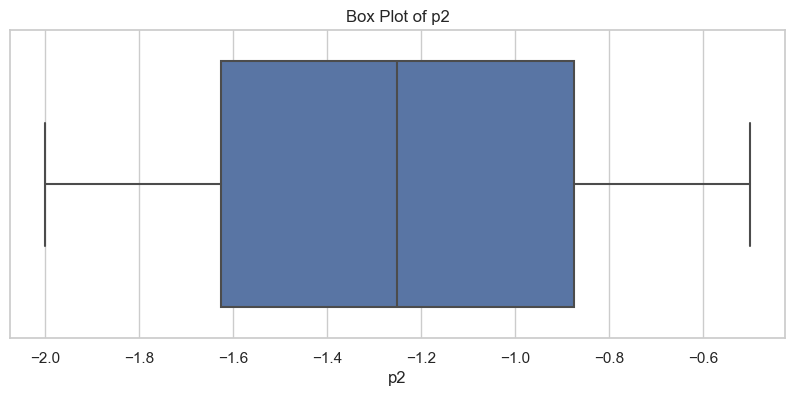

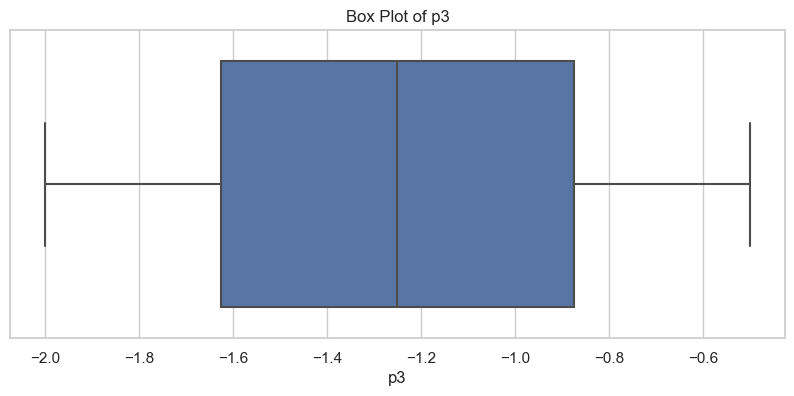

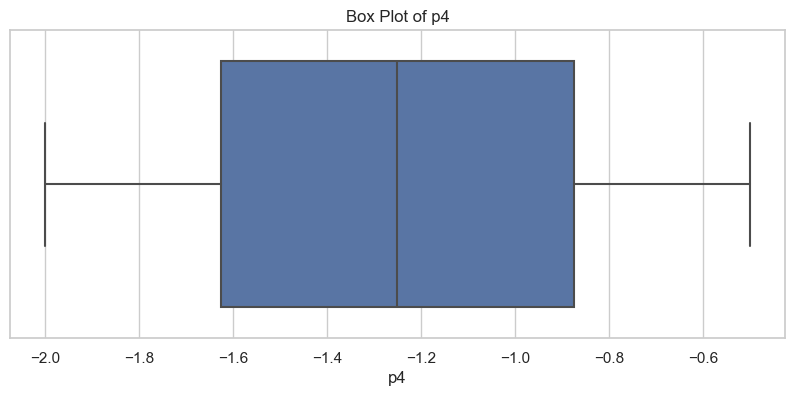

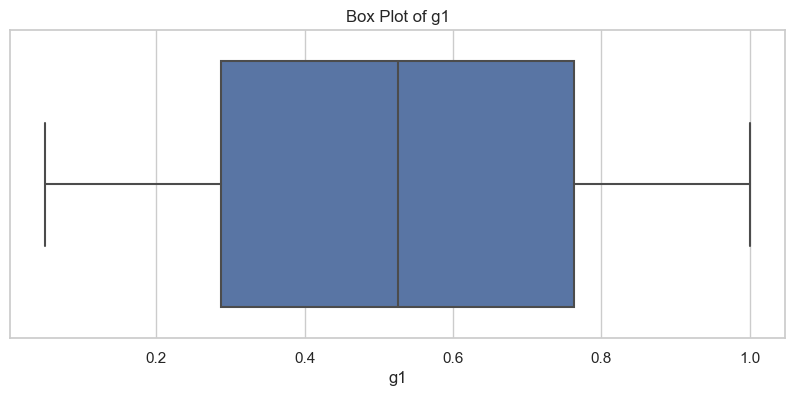

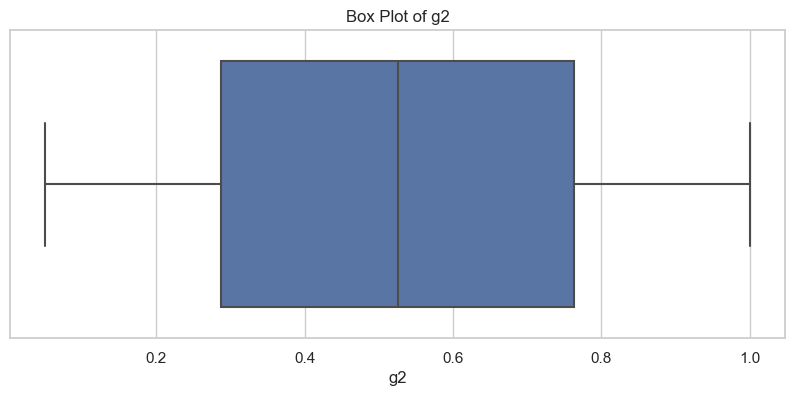

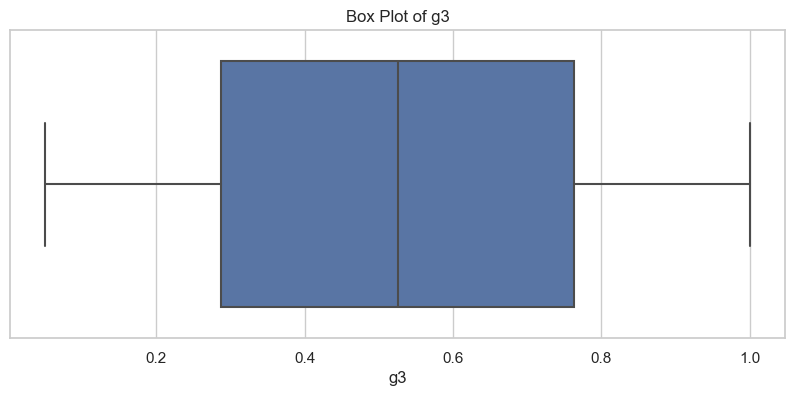

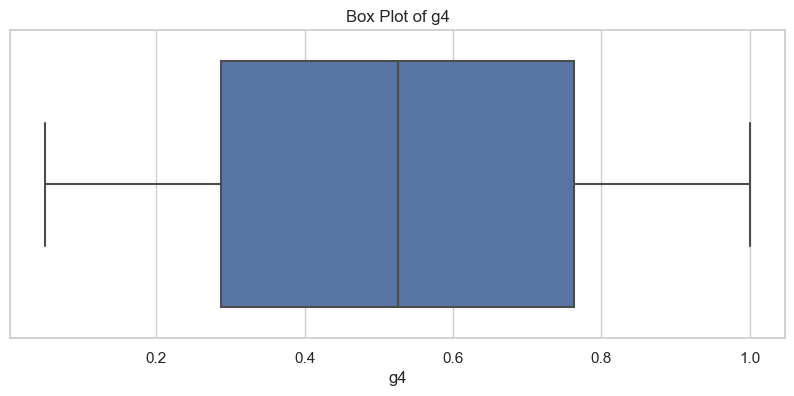

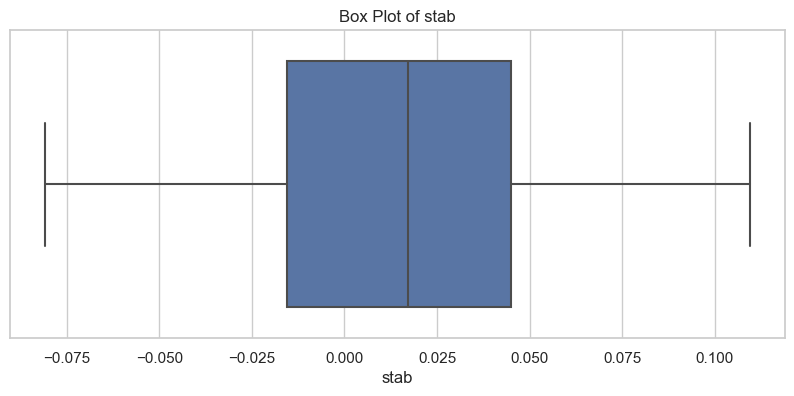

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Histograms for each numeric column
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[column], kde=True)  # KDE (Kernel Density Estimate) is added for smooth distribution curve
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Box plots for each numeric column
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.show()

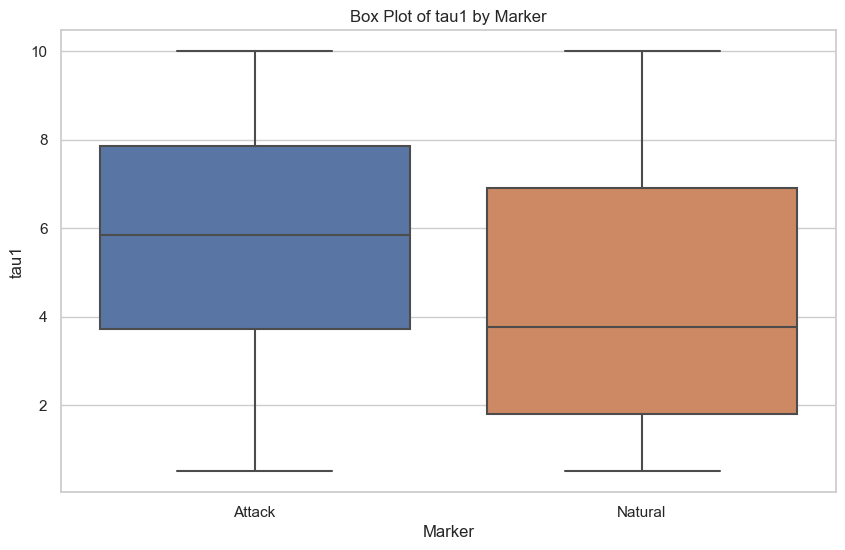

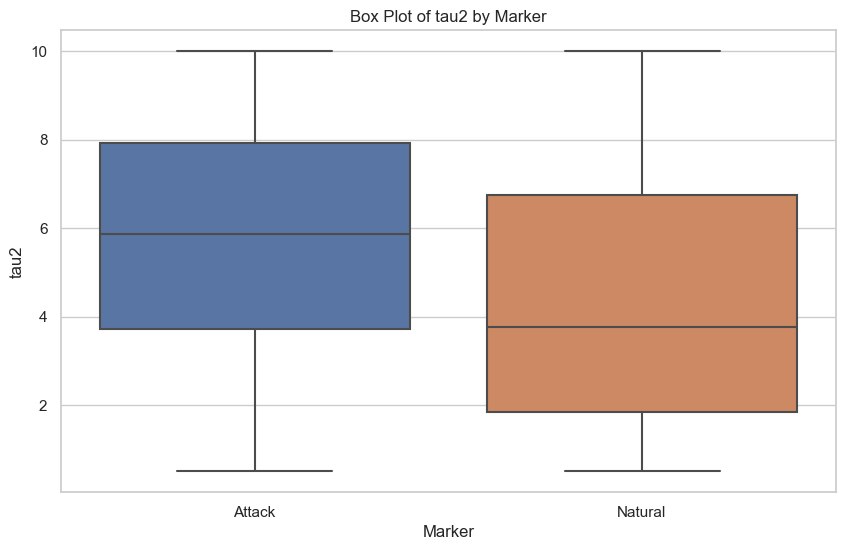

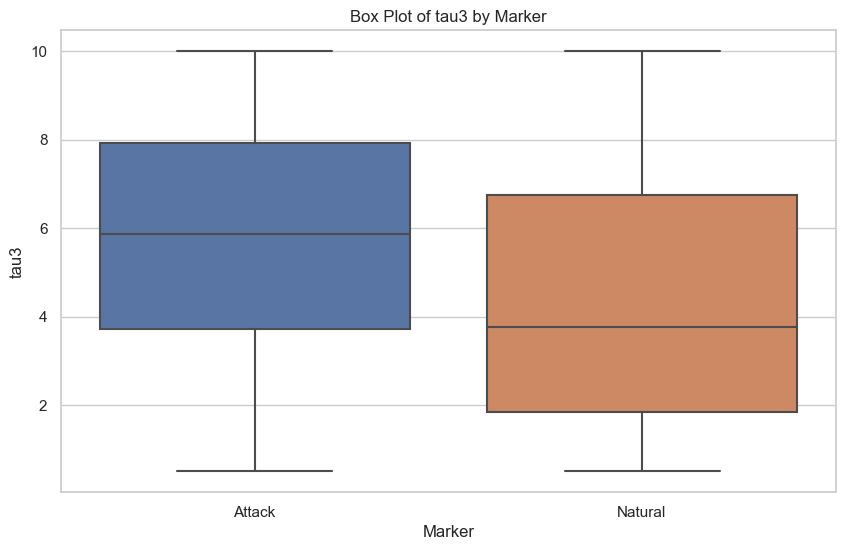

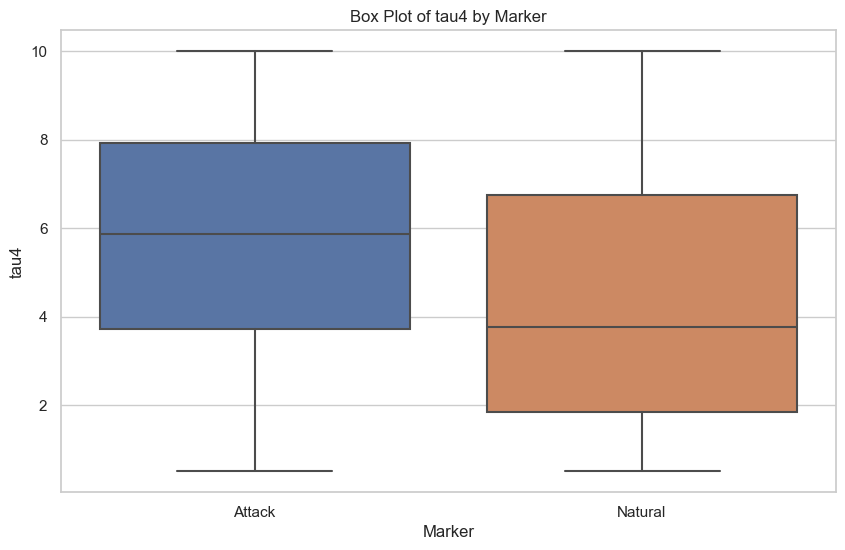

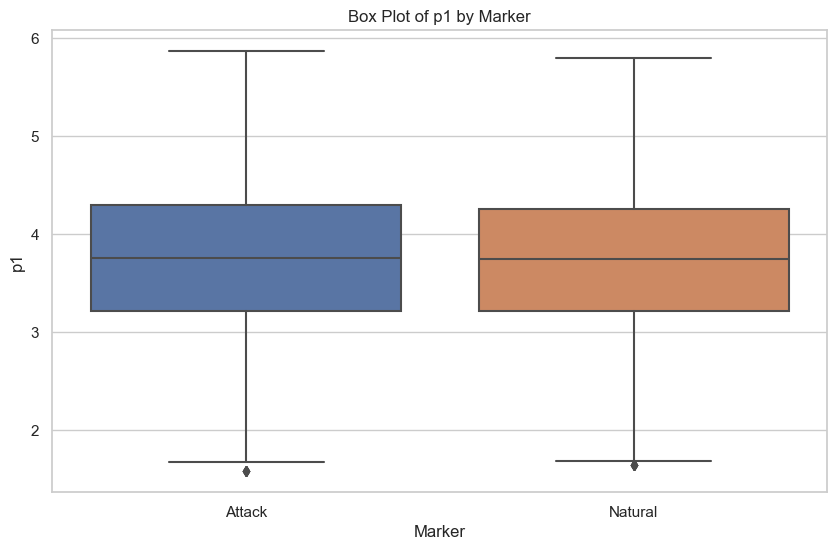

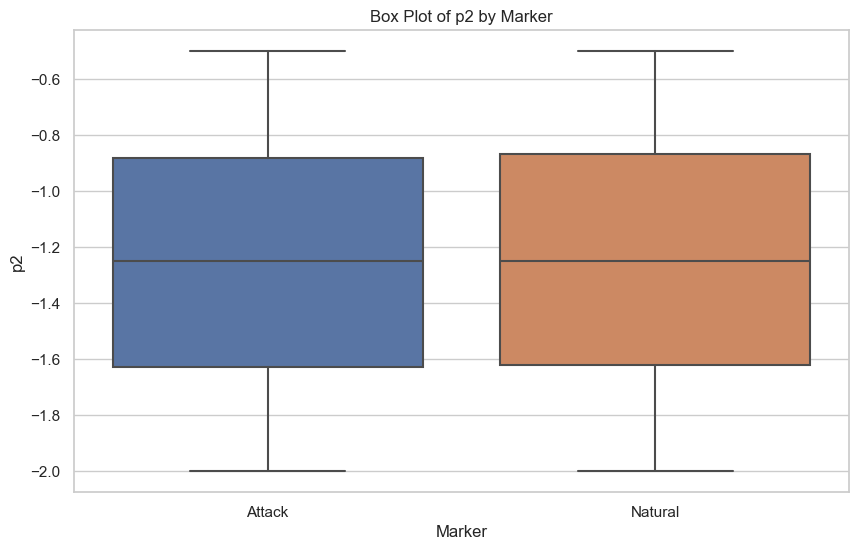

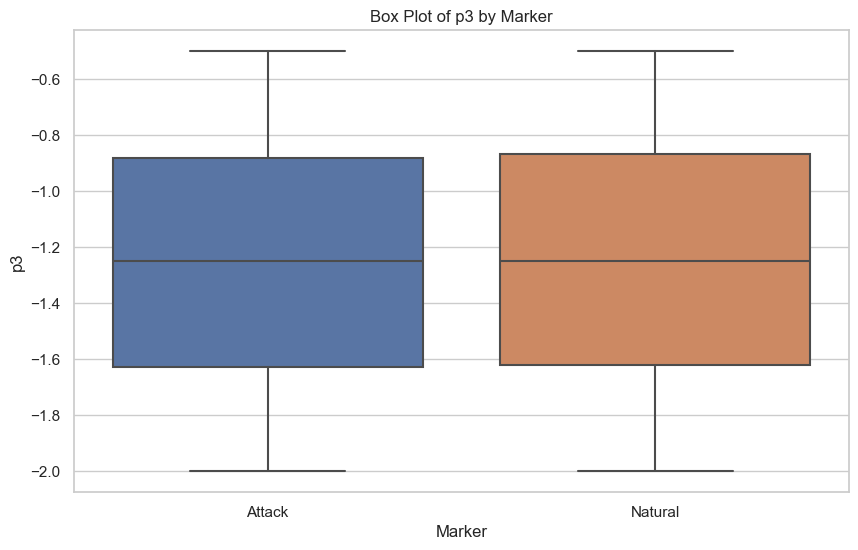

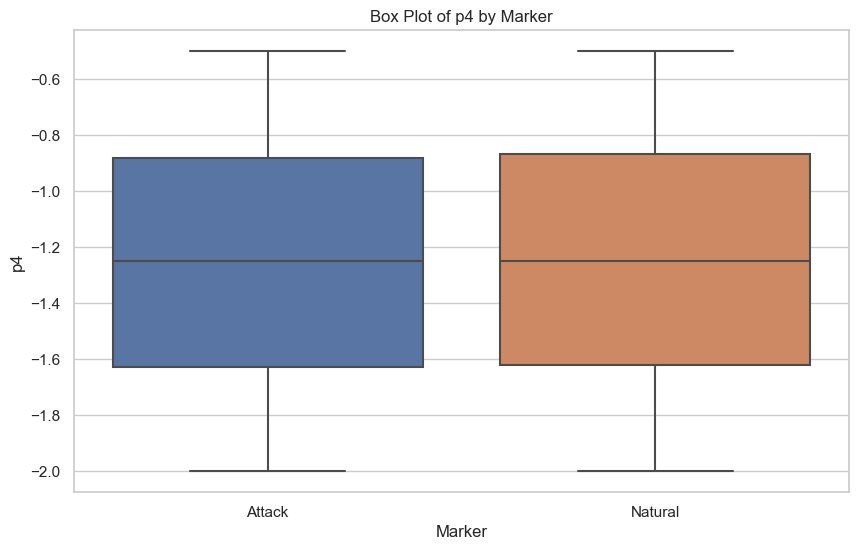

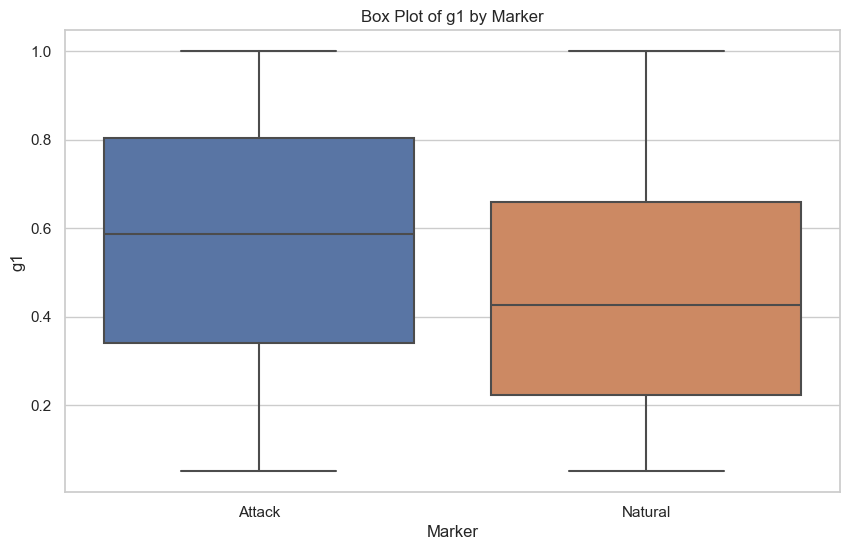

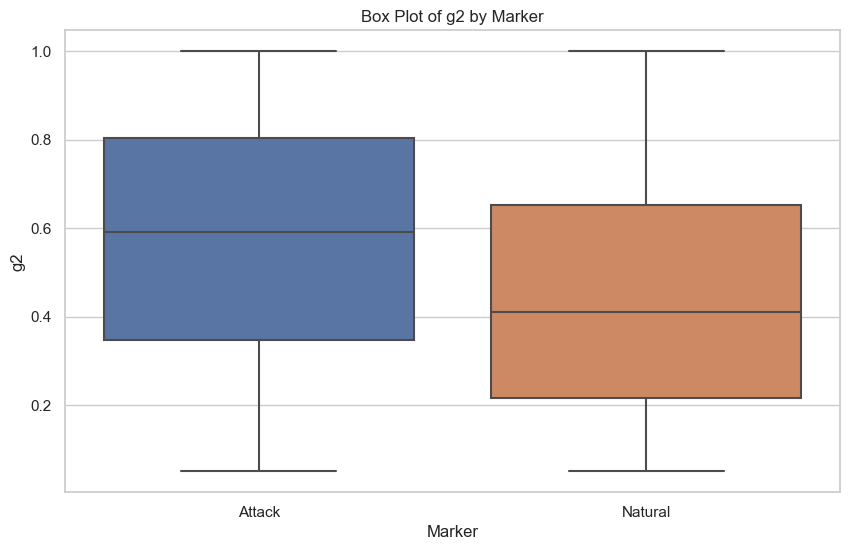

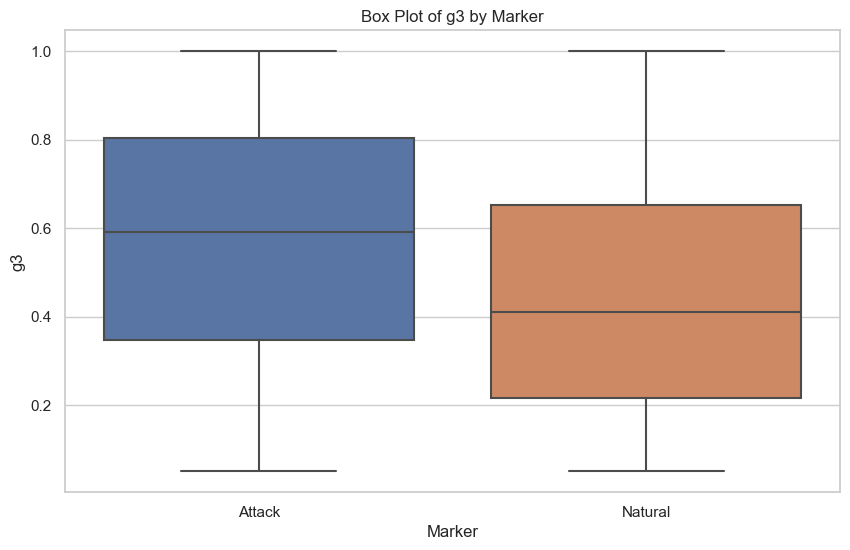

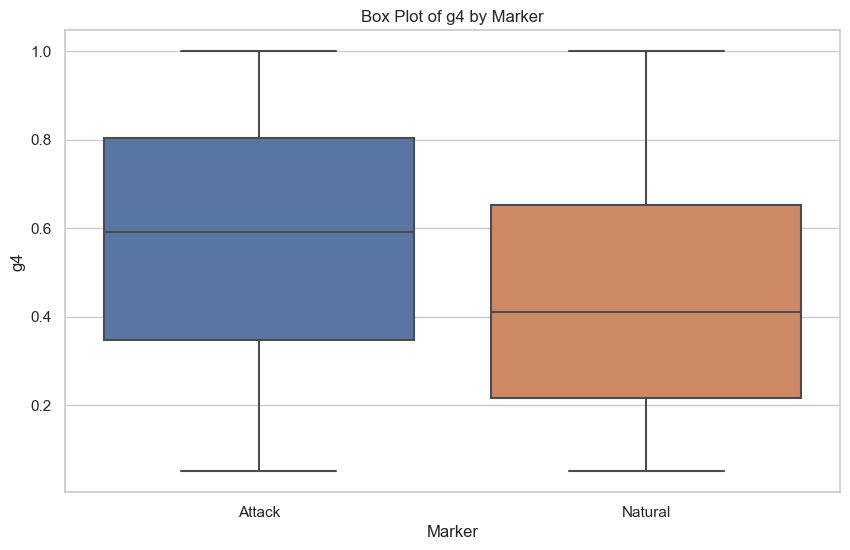

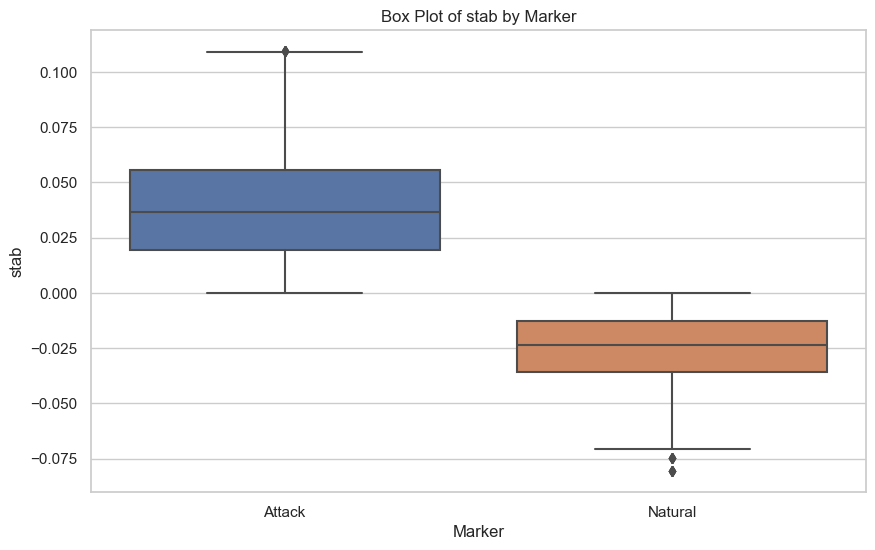

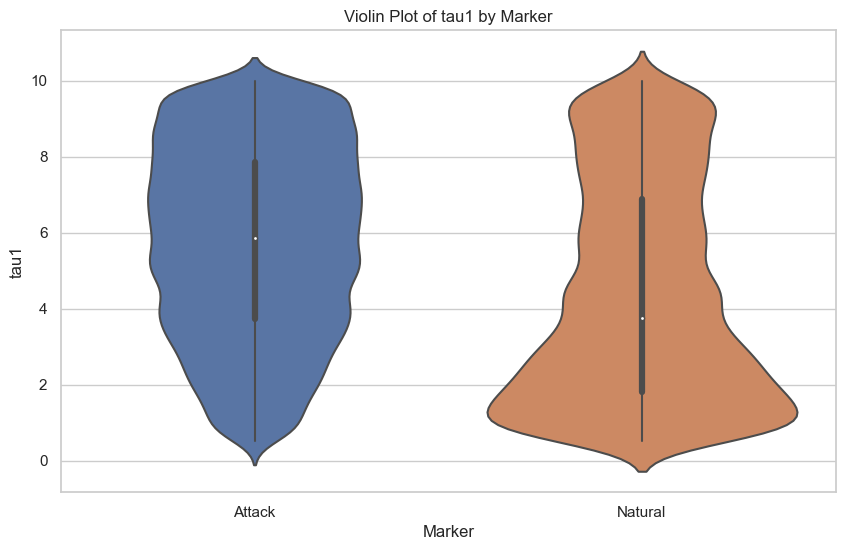

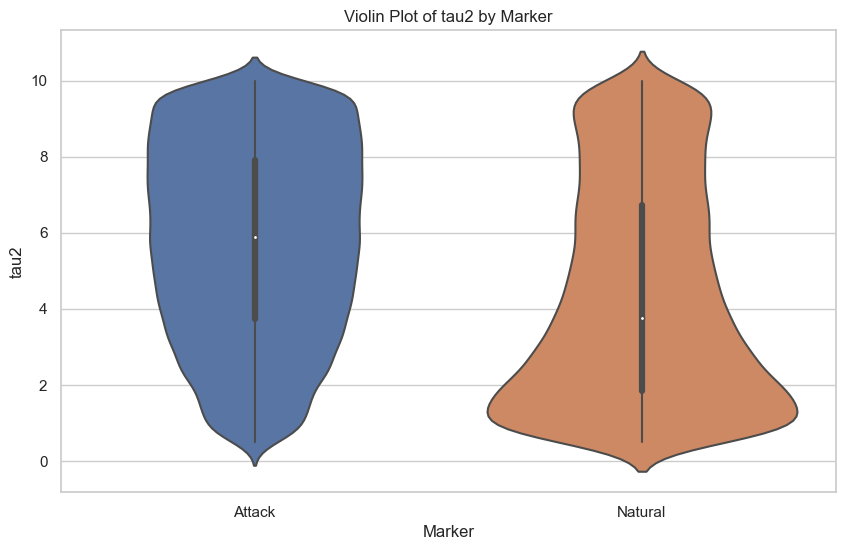

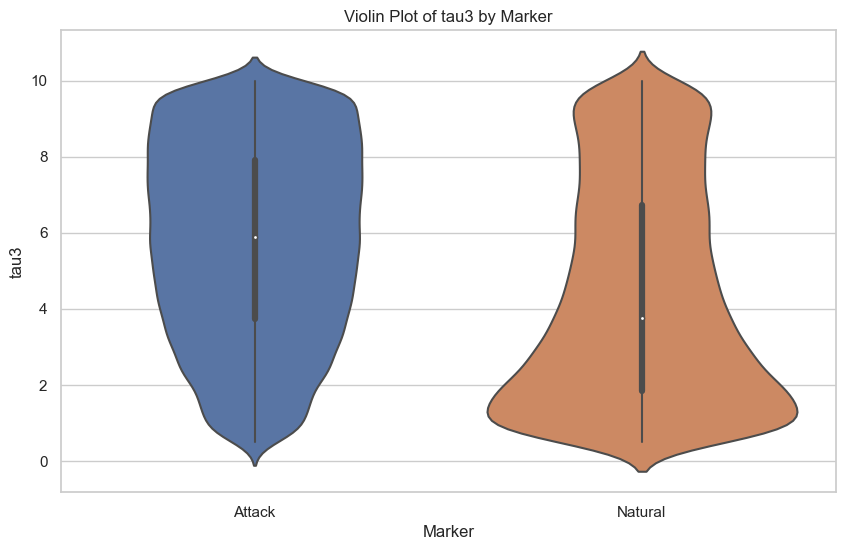

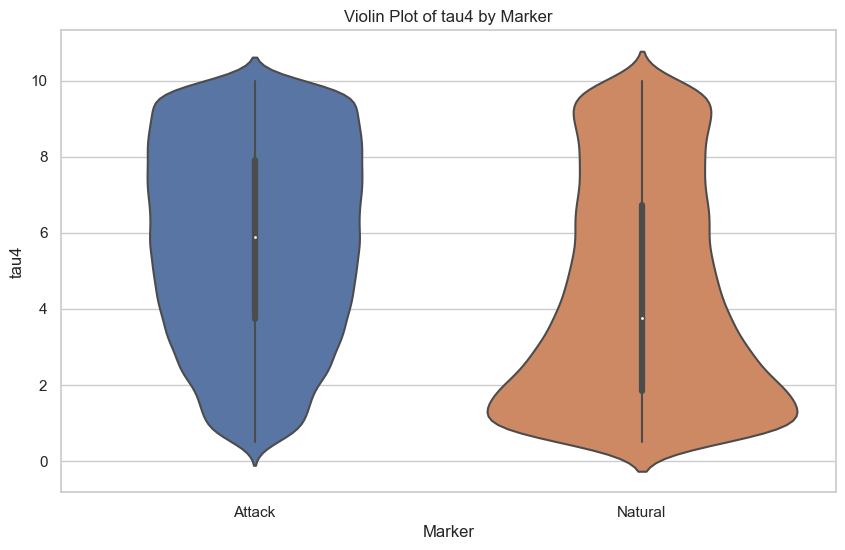

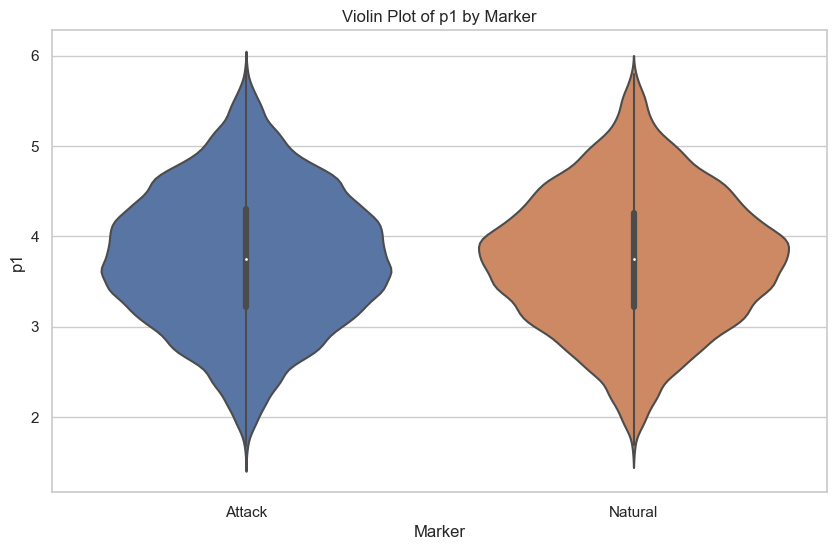

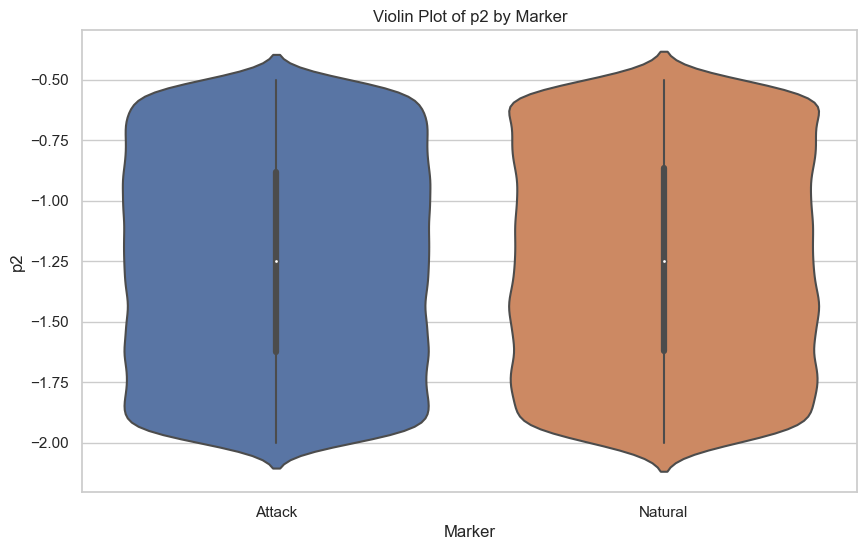

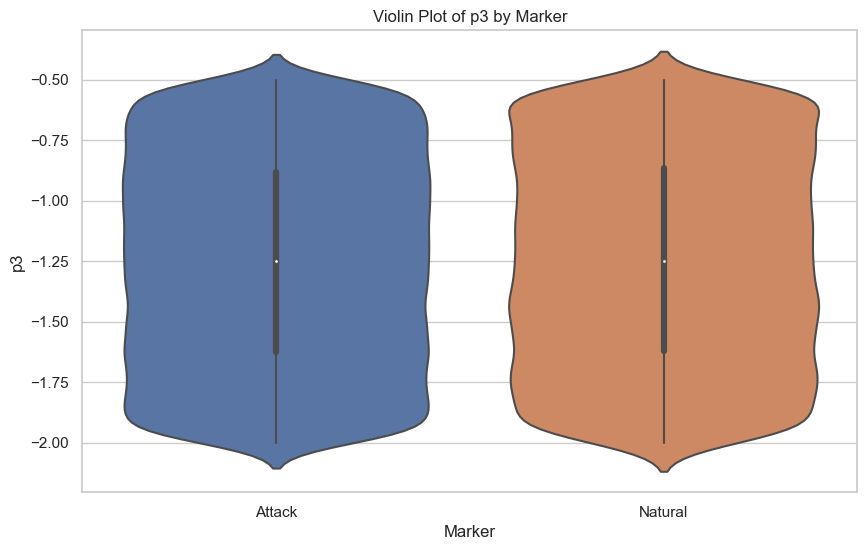

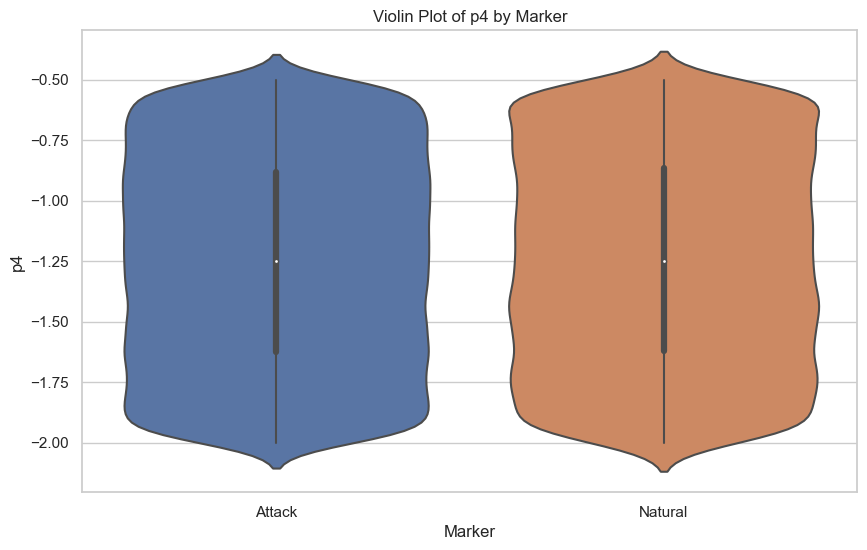

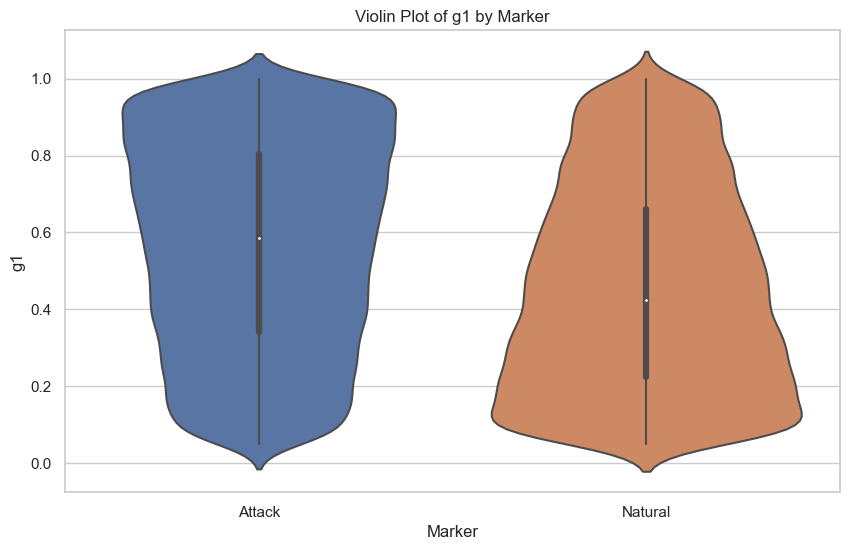

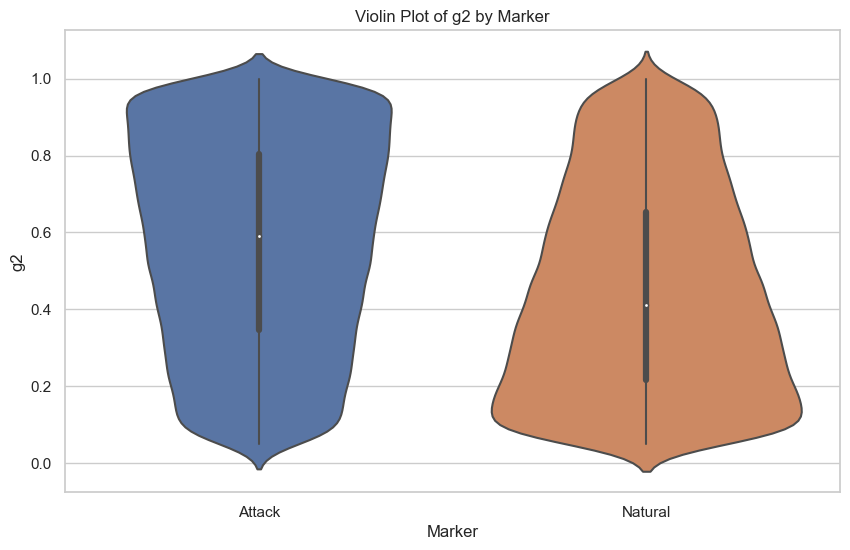

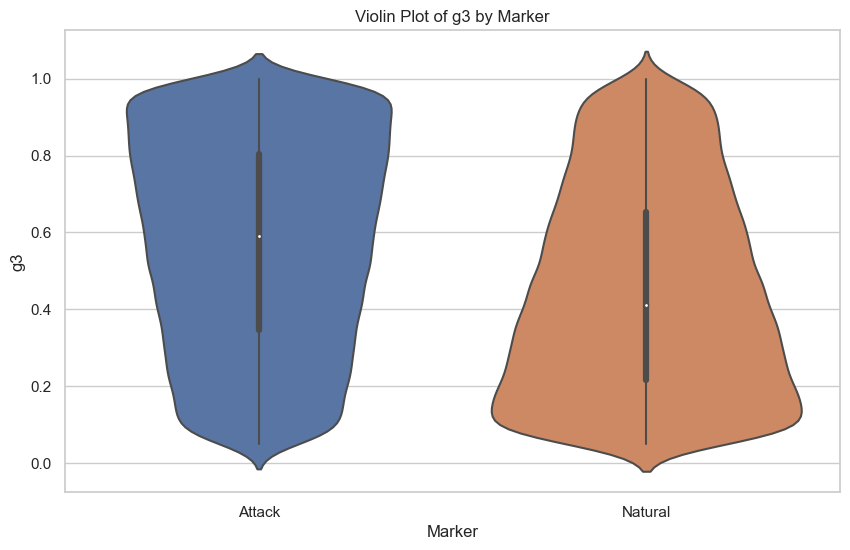

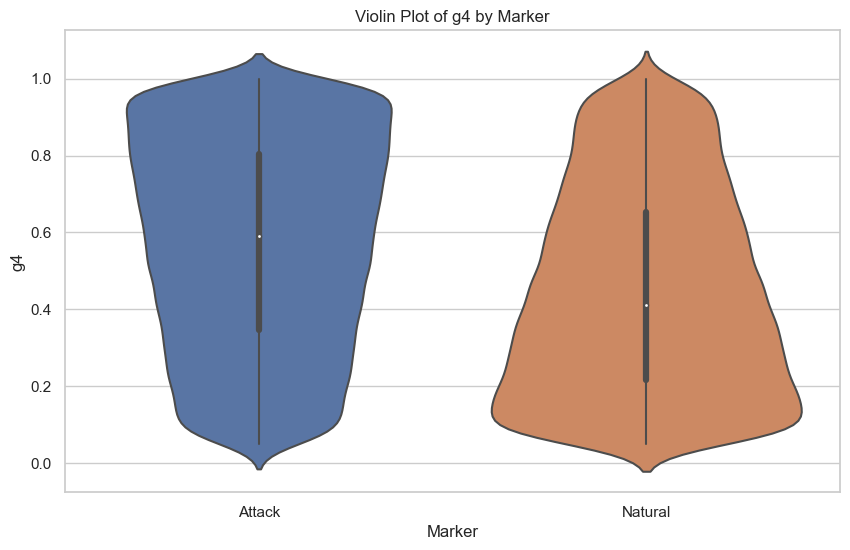

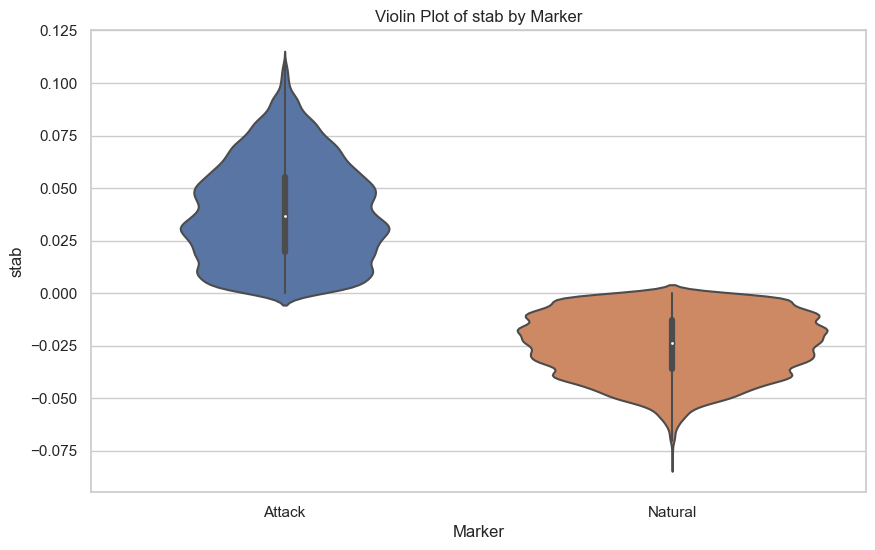

In [5]:
sns.set(style="whitegrid")

# Box plots for each numeric column grouped by 'marker'
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='marker', y=column, data=df)
    plt.title(f'Box Plot of {column} by Marker')
    plt.xlabel('Marker')
    plt.ylabel(column)
    plt.show()

# Violin plots for each numeric column grouped by 'marker'
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='marker', y=column, data=df)
    plt.title(f'Violin Plot of {column} by Marker')
    plt.xlabel('Marker')
    plt.ylabel(column)
    plt.show()

In [6]:


df.marker.unique() # Lets the program know how accurate it is



array(['Attack', 'Natural'], dtype=object)

In [7]:
# Use one-hot encoding to convert the 'marker' column
df_encoded = pd.get_dummies(df, columns=['marker'], drop_first=True) 

# Check the column names after encoding
print(df_encoded.columns)

# Calculate the correlation matrix
corr_matrix = df_encoded.corr()
corr_matrix



Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4', 'stab', 'marker_Natural'],
      dtype='object')


,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,marker_Natural
tau1,1.000000,-0.002550,-0.002550,-0.002550,0.027183,-0.015739,-0.015739,-0.015739,0.010521,0.006522,0.006522,0.006522,0.275761,-0.234898
tau2,-0.002550,1.000000,0.005554,0.005554,0.003004,-0.004473,-0.000372,-0.000372,-0.005832,0.009865,0.002102,0.002102,0.283417,-0.241049
tau3,-0.002550,0.005554,1.000000,0.005554,0.003004,-0.000372,-0.004473,-0.000372,-0.005832,0.002102,0.009865,0.002102,0.283417,-0.241049
tau4,-0.002550,0.005554,0.005554,1.000000,0.003004,-0.000372,-0.000372,-0.004473,-0.005832,0.002102,0.002102,0.009865,0.283417,-0.241049
p1,0.027183,0.003004,0.003004,0.003004,1.000000,-0.578983,-0.578983,-0.578983,0.000721,0.000341,0.000341,0.000341,0.010278,-0.009938
p2,-0.015739,-0.004473,-0.000372,-0.000372,-0.578983,1.000000,0.002833,0.002833,-0.000417,-0.002141,0.000774,0.000774,-0.005951,0.005754
p3,-0.015739,-0.000372,-0.004473,-0.000372,-0.578983,0.002833,1.000000,0.002833,-0.000417,0.000774,-0.002141,0.000774,-0.005951,0.005754
p4,-0.015739,-0.000372,-0.000372,-0.004473,-0.578983,0.002833,0.002833,1.000000,-0.000417,0.000774,0.000774,-0.002141,-0.005951,0.005754
g1,0.010521,-0.005832,-0.005832,-0.005832,0.000721,-0.000417,-0.000417,-0.000417,1.000000,0.004718,0.004718,0.004718,0.282774,-0.197664
g2,0.006522,0.009865,0.002102,0.002102,0.000341,-0.002141,0.000774,0.000774,0.004718,1.000000,-0.006939,-0.006939,0.293684,-0.218015


In [8]:
# Column to keep regardless of threshold
column_to_keep = 'marker_Natural'

# Create a set to store the columns to remove
columns_to_remove = set()

# Define the correlation threshold
correlation_threshold = 0.7  # Adjust this threshold as needed (0.85)

# Iterate through the columns and find pairs with correlations above or below the threshold
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        correlation_value = corr_matrix.iloc[i, j]
        if abs(correlation_value) >= correlation_threshold:  
            col_i = corr_matrix.columns[i]
            col_j = corr_matrix.columns[j]

            # Choose one column to remove (you can customize this logic)
            # For example, you can choose the column with the shorter name
            if len(col_i) <= len(col_j):
                if (column_to_keep != col_j):
                    columns_to_remove.add(col_j)
            else:
                if (column_to_keep != col_i):
                    columns_to_remove.add(col_i)

# Remove the identified columns
df_encoded_filtered = df_encoded.drop(columns=columns_to_remove)

In [9]:
def correlation_map(f_data, f_feature, f_number):
    """
    Develops and displays a heatmap plot referenced to a primary feature of a dataframe, highlighting
    the correlation among the 'n' mostly correlated features of the dataframe.
    
    Keyword arguments:
    
    f_data      Tensor containing all relevant features, including the primary.
                Pandas dataframe
    f_feature   The primary feature.
                String
    f_number    The number of features most correlated to the primary feature.
                Integer
    """
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"): 
        f_fig, f_ax = plt.subplots(figsize=(12, 12))
        sns.heatmap(f_correlation, mask=f_mask, vmin=-1, vmax=1, square=True,
                    center=0, annot=False, annot_kws={"size": 8}, cmap="PRGn")
    plt.show()



In [10]:
print(df_encoded_filtered.columns)

Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4', 'stab', 'marker_Natural'],
      dtype='object')


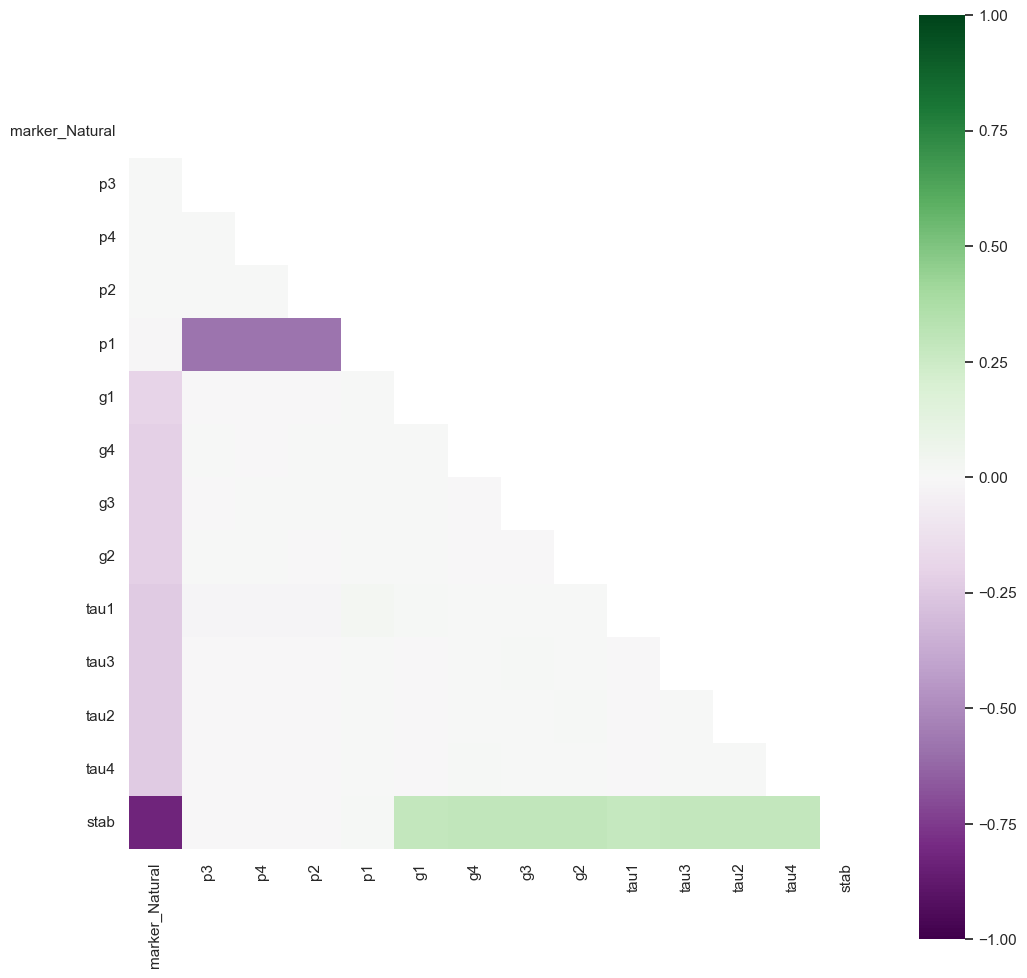

In [11]:
# Select 'marker_Natural' as the primary feature
correlation_map(df_encoded_filtered, 'marker_Natural', 37)



C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


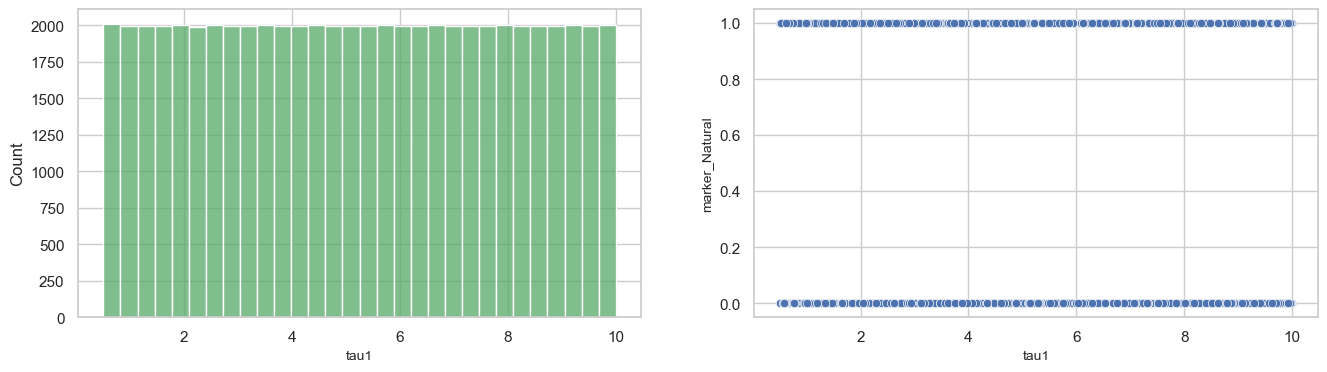

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


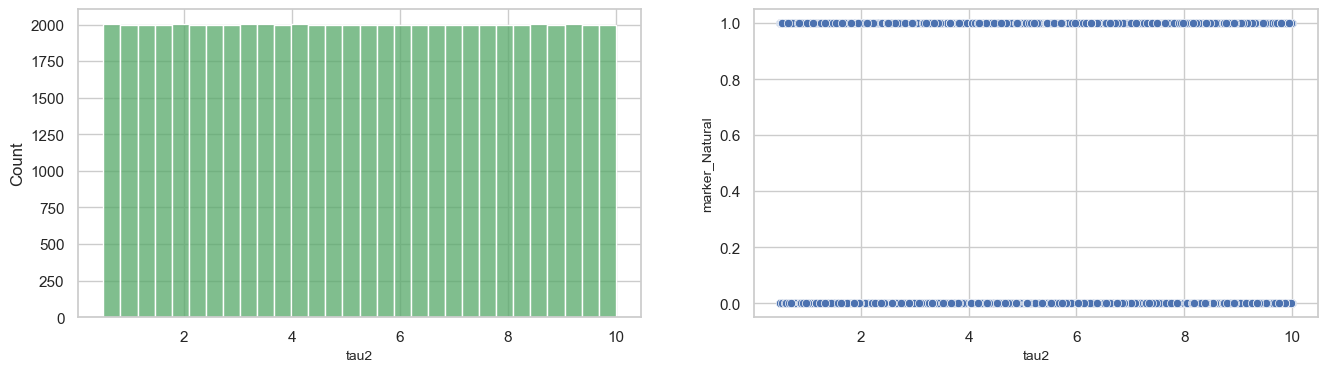

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


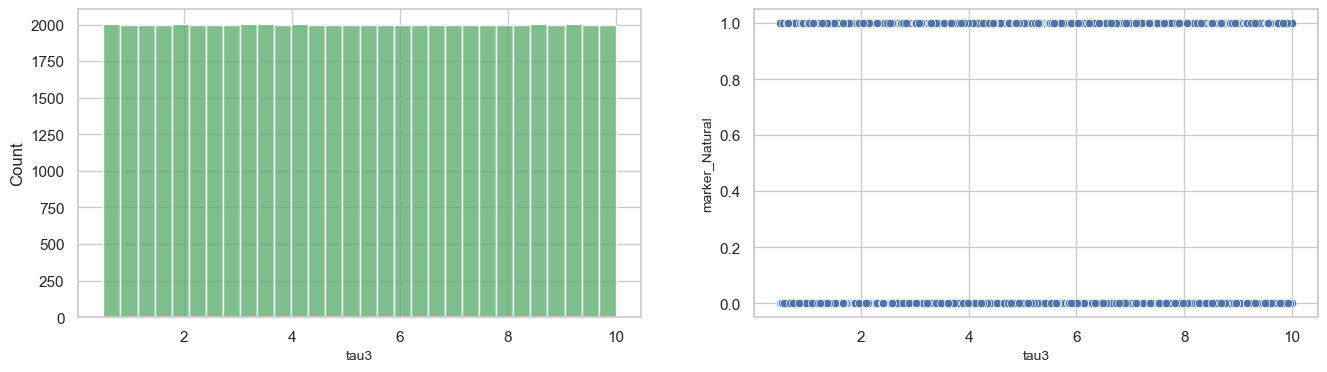

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


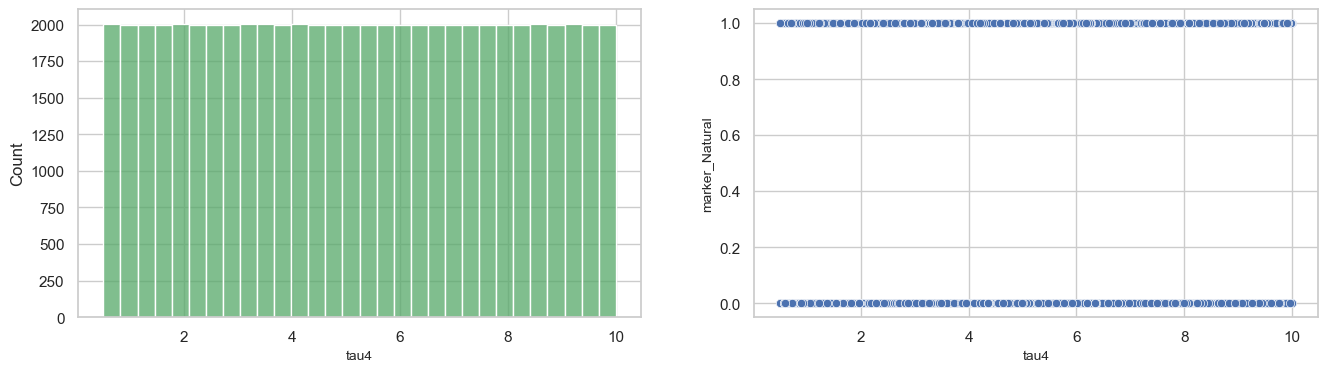

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


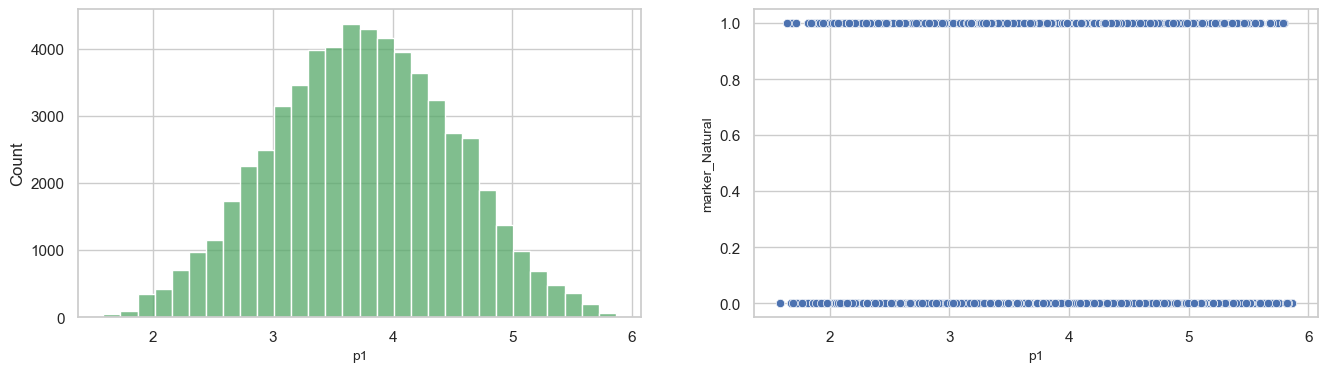

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


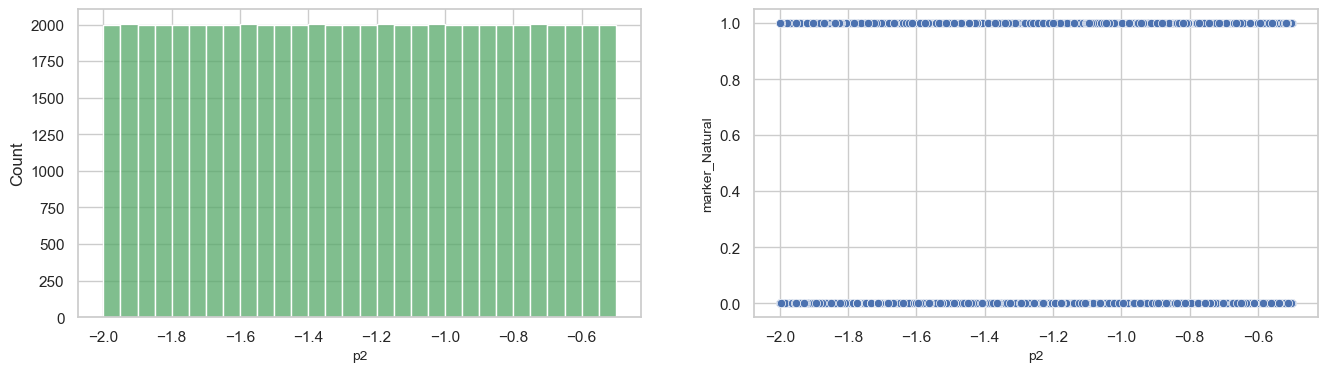

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


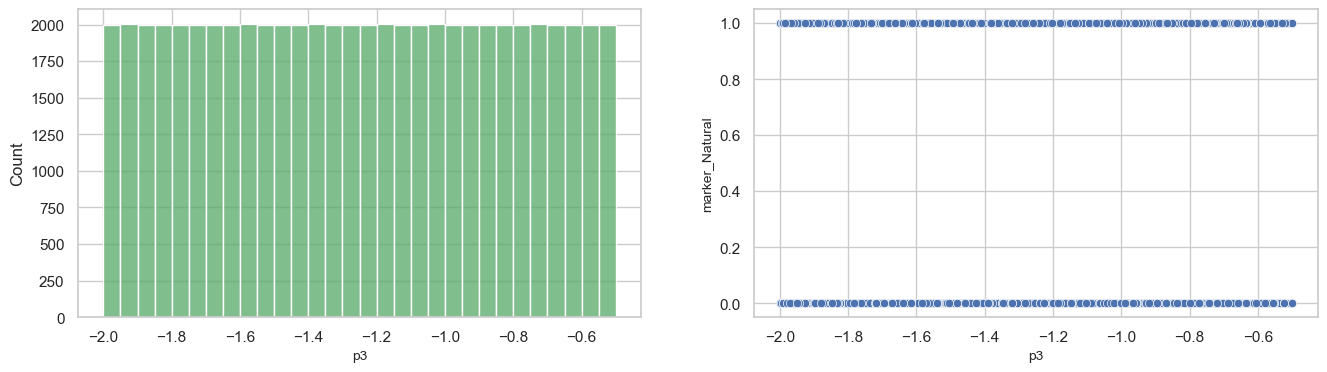

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


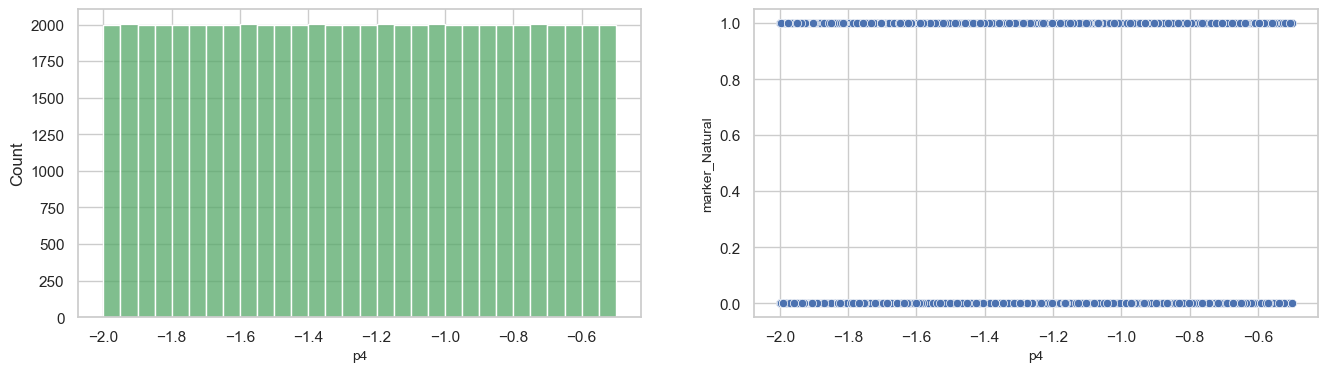

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


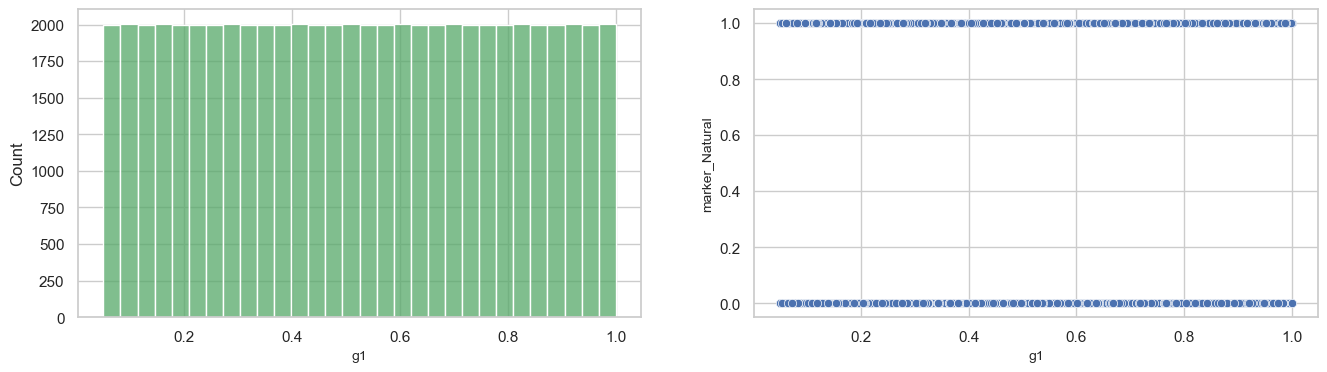

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


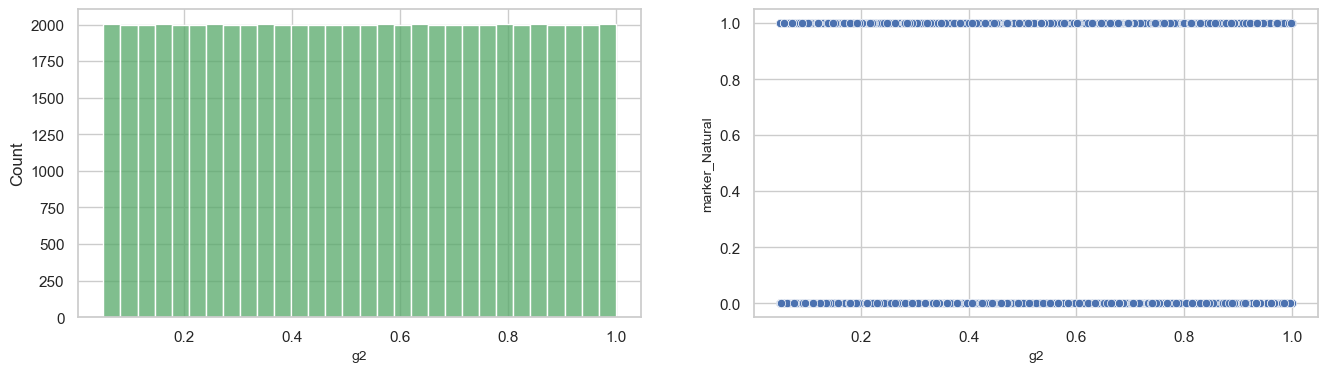

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


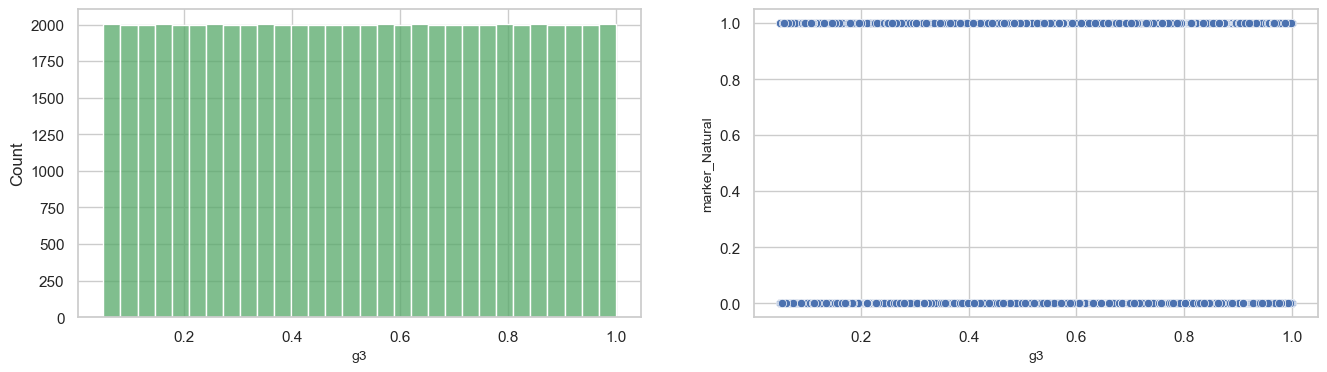

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


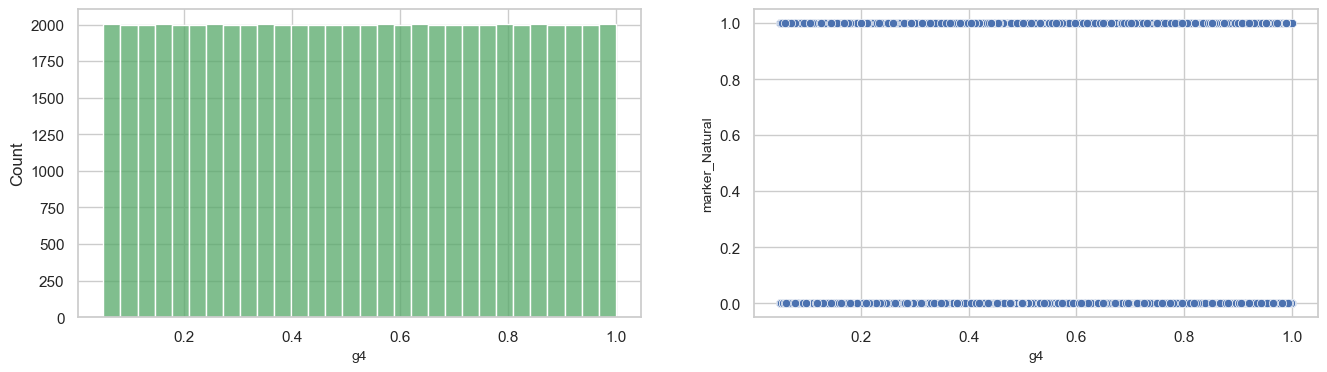

C:\Users\rvaru\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


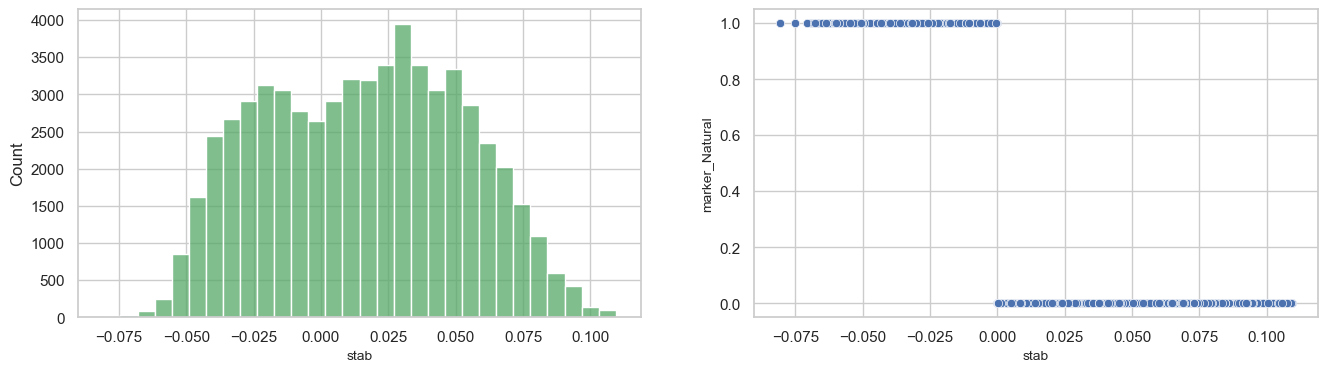

In [12]:
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns

# Define the assessment function
def assessment(f_data, f_y_feature, f_x_feature, f_index=-1):
    """
    Develops and displays a histogram and a scatter plot for a dependent / independent variable pair from
    a dataframe and, optionally, highlights a specific observation on the plot in a different color (red).
    
    Also optionally, if an independent feature is not informed, the scatterplot is not displayed.
    
    Keyword arguments:
    
    f_data      DataFrame containing the dependent / independent variable pair.
                Pandas DataFrame
    f_y_feature Dependent variable designation (e.g., 'marker_Attack').
                String
    f_x_feature Independent variable designation (e.g., column name).
                String
    f_index     If greater or equal to zero, the observation denoted by f_index will be plotted in red.
                Integer
    """
    # Determine the color for plotting
    if f_index >= 0:
        f_color = np.where(f_data.index == f_index, 'r', 'g')
        f_hue = None
    else:
        f_color = 'b'
        f_hue = None
    
    # Create subplots for histogram and scatter plot
    f_fig, f_a = plt.subplots(1, 2, figsize=(16, 4))
    
    # Plot histogram using sns.histplot with a fixed number of bins
    f_chart1 = sns.histplot(f_data[f_x_feature], ax=f_a[0], bins=30, color='g')
    f_chart1.set_xlabel(f_x_feature, fontsize=10)
    
    # Plot scatter plot (if independent feature is provided)
    if f_index >= 0:
        f_chart2 = plt.scatter(f_data[f_x_feature], f_data[f_y_feature], c=f_color, edgecolors='w')
        f_chart2 = plt.xlabel(f_x_feature, fontsize=10)
        f_chart2 = plt.ylabel(f_y_feature, fontsize=10)
    else:
        f_chart2 = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, hue=f_hue, legend=False)
        f_chart2.set_xlabel(f_x_feature, fontsize=10)
        f_chart2.set_ylabel(f_y_feature, fontsize=10)

    plt.show()

# Assess relationships for 'marker_Natural' and other columns in df_encoded_filtered
for column in df_encoded_filtered.columns:
    if column != 'marker_Natural':  # Skip the dependent variable itself
        assessment(df_encoded_filtered, 'marker_Natural', column, -1)

In [13]:
df_encoded_filtered.shape



(60000, 14)

In [14]:
lengthCol = len(df_encoded_filtered.columns)



In [15]:
X = df_encoded_filtered.iloc[:, :(lengthCol-2)] # Note: two less than df_encoded_filtered.shape column
y = df_encoded_filtered.iloc[:, (lengthCol-1)] # Note: one less than df_encoded_filtered.shape column
y



0        False
1         True
2        False
3        False
4        False
         ...  
59995    False
59996     True
59997     True
59998    False
59999    False
Name: marker_Natural, Length: 60000, dtype: bool

In [16]:
X_training = X.iloc[:3500, :]
y_training = y.iloc[:3500]

X_testing = X.iloc[3500:, :]
y_testing = y.iloc[3500:]

ratio_training = y_training.value_counts(normalize=True)
ratio_testing = y_testing.value_counts(normalize=True)
ratio_training, ratio_testing

(marker_Natural
 False    0.630571
 True     0.369429
 Name: proportion, dtype: float64,
 marker_Natural
 False    0.63846
 True     0.36154
 Name: proportion, dtype: float64)

In [17]:
X_training = X_training.values
y_training = y_training.values

X_testing = X_testing.values
y_testing = y_testing.values

X_testing



array([[7.59222336, 1.38950867, 7.28589559, ..., 0.46955836, 0.55976862,
        0.17052871],
       [9.20373904, 3.03113388, 2.74208849, ..., 0.94559662, 0.78677614,
        0.52785195],
       [4.01600415, 8.50112731, 5.34537329, ..., 0.30035604, 0.25177486,
        0.55997596],
       ...,
       [2.36403419, 8.77639096, 2.84203025, ..., 0.14928646, 0.98650532,
        0.14598403],
       [9.63151069, 2.75707093, 3.9943976 , ..., 0.88911835, 0.58755755,
        0.81839133],
       [6.53052662, 4.34969522, 6.7817899 , ..., 0.37876093, 0.50544105,
        0.94263083]])

In [18]:


y_testing



array([False, False, False, ...,  True, False, False])

In [19]:
scaler = StandardScaler()
X_training = scaler.fit_transform(X_training)
X_testing = scaler.transform(X_testing)



In [20]:

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam

# Initialize the classifier as a Sequential model
classifier = Sequential()

# Define the input shape explicitly using an Input layer
classifier.add(Input(shape=(lengthCol-2,)))

# First hidden layer
classifier.add(Dense(units=lengthCol-2, kernel_initializer='uniform', activation='relu'))

# Second hidden layer
classifier.add(Dense(units=lengthCol-2, kernel_initializer='uniform', activation='sigmoid'))

# Third hidden layer (seems to serve the same role as the second)
classifier.add(Dense(units=lengthCol-2, kernel_initializer='uniform', activation='sigmoid'))

# Output layer with a single node (for binary classification)
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Compile the ANN
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Example of another model structure that includes dropout layers
model = Sequential([
    Dense(128, activation='relu', input_shape=(lengthCol-2,)),
    Dropout(0.05),  # Dropout layer to reduce overfitting
    Dense(64, activation='relu'),
    Dropout(0.05),
    Dense(32, activation='relu'),
    Dropout(0.05),
    Dense(16, activation='relu'),
    Dropout(0.05),
    Dense(8, activation='relu'),
    Dropout(0.05),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])



C:\Users\rvaru\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
cross_val_round = 1
print(f'Model evaluation\n')

for train_index, val_index in KFold(10, shuffle=True, random_state=10).split(X_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train ,y_val = y_training[train_index], y_training[val_index]
    # (Epochs): used to separate training into distinct phases, which is useful for logging and periodic evaluation.
    # Therefore, the more epochs, the more the model is trained.
    classifier.fit(x_train, y_train, epochs=25, verbose=0)
    classifier_loss, classifier_accuracy = classifier.evaluate(x_val, y_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1



Model evaluation

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7636 - loss: 0.4719  
Round 1 - Loss: 0.4473 | Accuracy: 79.14 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8175 - loss: 0.4036 
Round 2 - Loss: 0.3866 | Accuracy: 81.71 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9316 - loss: 0.1592 
Round 3 - Loss: 0.1764 | Accuracy: 92.29 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8904 - loss: 0.2288 
Round 4 - Loss: 0.2357 | Accuracy: 89.71 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9656 - loss: 0.1124 
Round 5 - Loss: 0.1100 | Accuracy: 96.29 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9441 - loss: 0.1345 
Round 6 - Loss: 0.1482 | Accuracy: 94.29 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9397 - loss: 0.1484 
Round 7 - Loss: 0.1433 | Accuracy: 93.43 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9164 - loss: 0.1990 
Round 8 - Loss: 0.1941 | Accuracy: 92.29 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

In [22]:
y_pred = classifier.predict(X_testing)
y_pred



1766/1766 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


array([[8.8710392e-01],
       [5.3029399e-02],
       [3.4128691e-04],
       ...,
       [9.9838036e-01],
       [2.9966832e-04],
       [1.0381015e-04]], dtype=float32)

In [23]:
# Fixes binary errors with confusion_matrix
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1



In [24]:
confusion_matrix(y_testing, y_pred)

array([[34220,  1853],
       [ 2079, 18348]], dtype=int64)

In [25]:
cm = pd.DataFrame(data=confusion_matrix(y_testing, y_pred, labels=[0, 1]),
                  index=["Actual Attack", "Actual Natural"],
                  columns=["Predicted Attack", "Predicted Natural"])
cm



,Predicted Attack,Predicted Natural
Actual Attack,34220,1853
Actual Natural,2079,18348


In [26]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_testing) * 100):.2f}%')



Accuracy per the confusion matrix: 93.04%


In [27]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l1_l2
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping

# Assuming X_training, y_training, and X_testing, y_testing are already defined

# Define the neural network architecture with added L1 and L2 regularization
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.005, l2=0.005), input_shape=(X_training.shape[1],)),
    Dropout(0.3),  # Adjusted dropout rate
    BatchNormalization(),
    Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.005, l2=0.005)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.005, l2=0.005)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

# Compile the model with an adjusted learning rate and optimizer
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

print('Model evaluation\n')

# Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
cross_val_round = 1

for train_index, val_index in skf.split(X_training, y_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train, y_val = y_training[train_index], y_training[val_index]

    # Fit the model
    model.fit(x_train, y_train, epochs=50, verbose=0, validation_data=(x_val, y_val), callbacks=[early_stopping_monitor])
    classifier_loss, classifier_accuracy = model.evaluate(x_val, y_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1

# Predicting the test set results
y_pred = model.predict(X_testing)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

# Confusion matrix
cm = pd.DataFrame(data=confusion_matrix(y_testing, y_pred, labels=[0, 1]),
                  index=["Actual Attack", "Actual Natural"],
                  columns=["Predicted Attack", "Predicted Natural"])
print(cm)

# Accuracy from the confusion matrix
accuracy = ((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_testing) * 100)
print(f'Accuracy per the confusion matrix: {accuracy:.2f}%')


Model evaluation



C:\Users\rvaru\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8484 - loss: 1.0092 
Round 1 - Loss: 0.9912 | Accuracy: 85.71 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9130 - loss: 0.4093 
Round 2 - Loss: 0.3971 | Accuracy: 91.14 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9407 - loss: 0.2438 
Round 3 - Loss: 0.2204 | Accuracy: 96.29 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9643 - loss: 0.2092 
Round 4 - Loss: 0.2233 | Accuracy: 96.29 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9680 - loss: 0.2095 
Round 5 - Loss: 0.2159 | Accuracy: 96.00 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9326 - loss: 0.2457 
Round 6 - Loss: 0.2264 | Accuracy: 95.43 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9487 - loss: 0.2185 
Round 7 - Loss: 0.2056 | Accuracy: 96.29 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9628 - loss: 0.2230 
Round 8 - Loss: 0.2158 | Accuracy: 95.71 %
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9768 - loss